In [2]:
import pandas as pd


C:\Users\rjaques\AppData\Local\Temp\ipykernel_13280\2035458946.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [12]:
#df = pd.read_csv(r'\\trllimited\data\Vehicle_Validation_SCANNER\Accreditation\2023\WDM\RAV16\Plates\LONG-PM-NS-R1_R16_230302151337_S1_TEX.dat')
df = pd.read_csv(r'\\trllimited\data\INF_TRACS\TRACS5\1 - Accreditation\RAV17\5-Accreditation-May23\CC Output\TRACS4\Plates\Texture\RAV17_NS_Run_1_A.dat')

In [13]:
minimum_texture = min(df.Texture)

adjustment_value = abs(minimum_texture)

#df.adjusted_Tex = df.Texture + adjustment_value
df['adjusted_Tex'] = df.apply(lambda row: row.Texture + adjustment_value, axis=1)

readings_per_metre = len(df.Chainage) / max(df.Chainage)
print("readings per metre", readings_per_metre)
hertz = readings_per_metre/2
print("hertz", hertz)

readings per metre 1004.9065493028047
hertz 502.45327465140235


16724


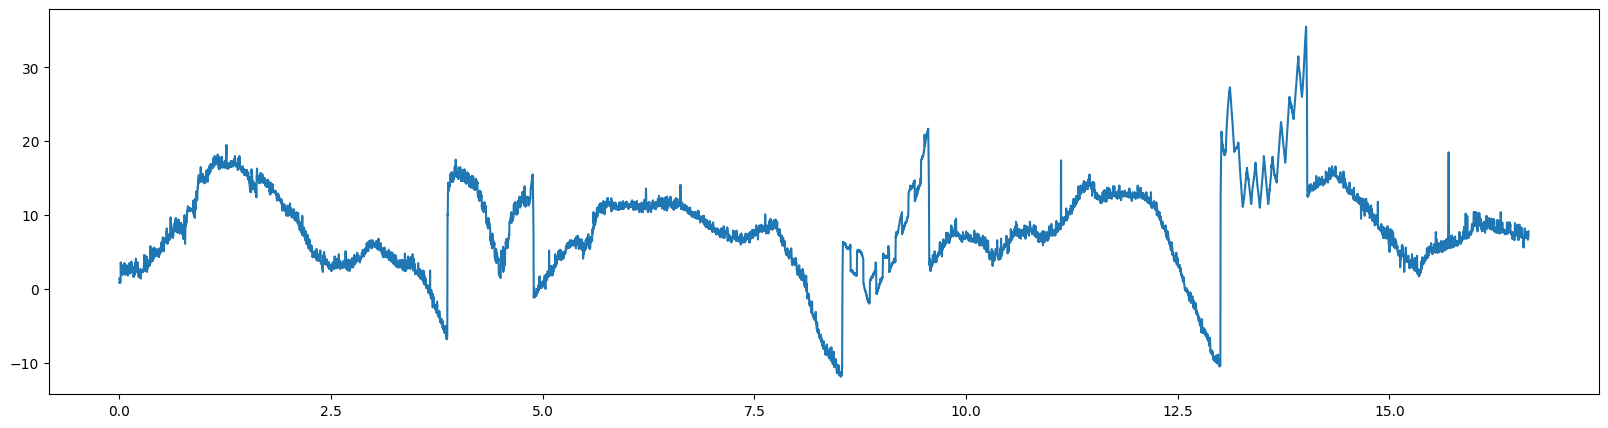

In [14]:
from matplotlib import pyplot as plt


print(len(df.Chainage))
plt.subplots(figsize=(20,5))
plt.plot(df.Chainage, df.Texture)

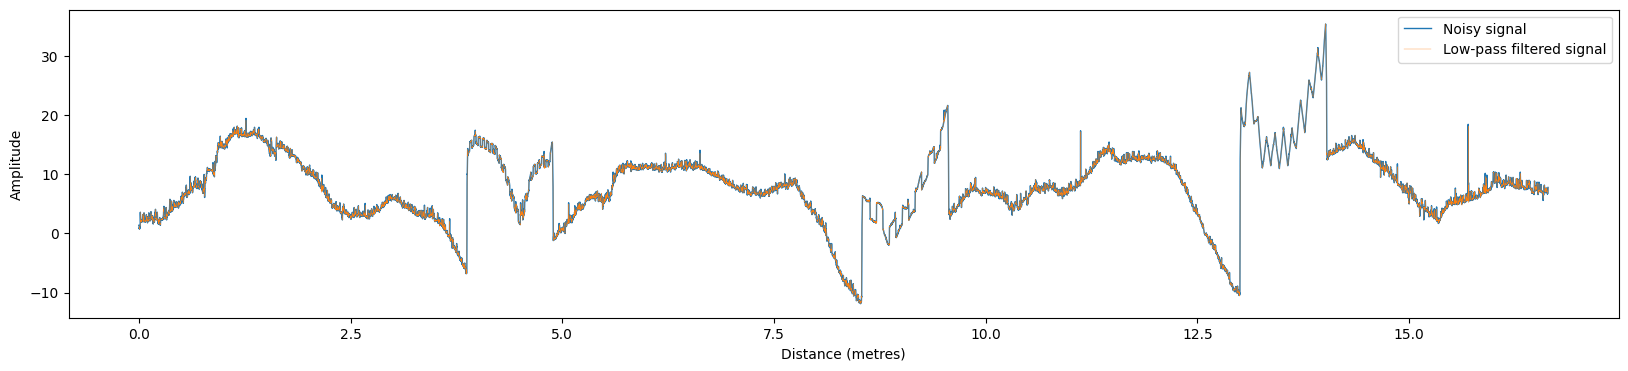

In [24]:
#TODO

#filter ot the 500Hz noise. The hertz is hertz from above...
# is has been suggested by MC to reduce the filter frequency.

# Import the required packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, savgol_filter
import noisereduce as nr

# Generate a noisy signal
# np.random.seed(0)
# fs = 1000 # sampling frequency
# t = np.linspace(0, 1, fs) # time vector
# f = 5 # signal frequency
# x = np.sin(2 * np.pi * f * t) # clean signal
# noise = 0.5 * np.random.randn(fs) # white noise
# y = x + noise # noisy signal

# t should be time, in this case it's distance
t = df.Chainage
# f=frequency which is the number of readings per metre /2 it assumes a sine wave !
f=500 # (near enough)
# y is the actual data (Texture)
y=df.Texture
# fs is sample frequency, so length of Texture (number of readings)/ max of the sample chainage(length of data in metres)
fs=(len(df.Texture)/ max(df.Chainage))

# Plot the noisy signal
# plt.figure(figsize=(12, 4))
# plt.plot(t, y, label='Noisy signal')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.show()

# Apply a low-pass filter
fc = 400 # cut-off frequency
w = fc / (fs / 2) # normalized frequency
b, a = butter(4, w, 'low') # 4th order low-pass Butterworth filter
y_lp = filtfilt(b, a, y) # apply the filter to the signal

# Plot the filtered signal
plt.figure(figsize=(20, 4))
plt.plot(t, y, label='Noisy signal',linewidth=1)
plt.plot(t, y_lp, label='Low-pass filtered signal',linewidth=0.25)
plt.xlabel('Distance (metres)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [ ]:

# Apply a smoothing algorithm
y_sg = savgol_filter(y, 51, 3) # apply a Savitzky-Golay filter

# Plot the smoothed signal
plt.figure(figsize=(12, 4))
plt.plot(t, y, label='Noisy signal')
plt.plot(t, y_sg, label='Savitzky-Golay smoothed signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Apply a noise reduction algorithm
y_nr = nr.reduce_noise(y, x, method='spectral_subtraction') # apply spectral gating

# Plot the noise reduced signal
plt.figure(figsize=(12, 4))
plt.plot(t, y, label='Noisy signal')
plt.plot(t, y_nr, label='Noise reduced signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()




In [7]:
from scipy import fftpack
import numpy as np
signal_noise = df.Texture
sec = readings_per_metre/2
time = np.linspace(0, len(df.Texture), len(df.Texture), endpoint=True).astype(int)

sig_noise_fft = fftpack.fft(signal_noise.values)
sig_noise_amp = 2 / time.size * np.abs(sig_noise_fft)
sig_noise_freq = np.abs(fftpack.fftfreq(time.size, readings_per_metre))

In [8]:
print(sig_noise_amp)
print(sig_noise_freq)

[56.50992384  8.51451731  3.86922468 ...  7.86300785  3.86922468
  8.51451731]
[0.0000000e+00 1.1473147e-07 2.2946294e-07 ... 3.4419441e-07 2.2946294e-07
 1.1473147e-07]


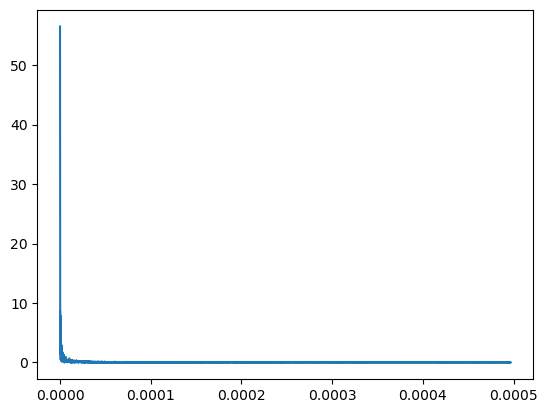

In [9]:
plt.plot(sig_noise_freq, sig_noise_amp)

In [10]:
signal_amplitude = pd.Series(sig_noise_amp).nlargest(2).round(0).astype(int).tolist()
print(signal_amplitude)

[57, 9]


In [11]:
#Calculate Frequency Magnitude
magnitudes = abs(sig_noise_fft[np.where(sig_noise_freq >= 0)])
#Get index of top 2 frequencies
peak_frequency = np.sort((np.argpartition(magnitudes, -2)[-2:])/sec)
print(peak_frequency)

[0.         0.00198853]


In [38]:
from scipy.signal import butter,filtfilt
# Filter requirements.
#fs = 1000.0       # sample rate, Hz
fs=400
cutoff = peak_frequency[1]     # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 2 Hz
order = 2       # sin wave can be approx represented as quadratic
def butter_lowpass_filter(data, cutoff, fs, order):
    print("Cutoff freq " + str(cutoff))
    nyq = 0.5 * fs # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a,data)
    return y
# Filter the data, and plot filtered signals.
y = butter_lowpass_filter(signal_noise, cutoff, fs, order)

Cutoff freq 0.0019885258396030465


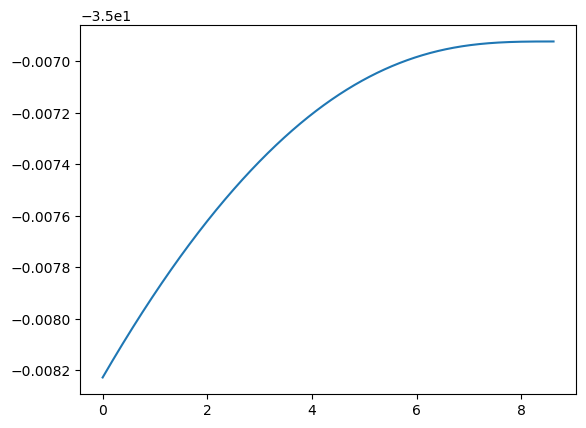

In [39]:
plt.plot(df.Chainage, y)

In [40]:
import numpy as np
from scipy import signal
data = {}
data['before'] = df.Texture
data['after_fir'] = signal.lfilter(np.ones(len(data)), 1, data['before'])
data['after_iir'] = signal.lfilter([1], [1,-0.5], data['before'])



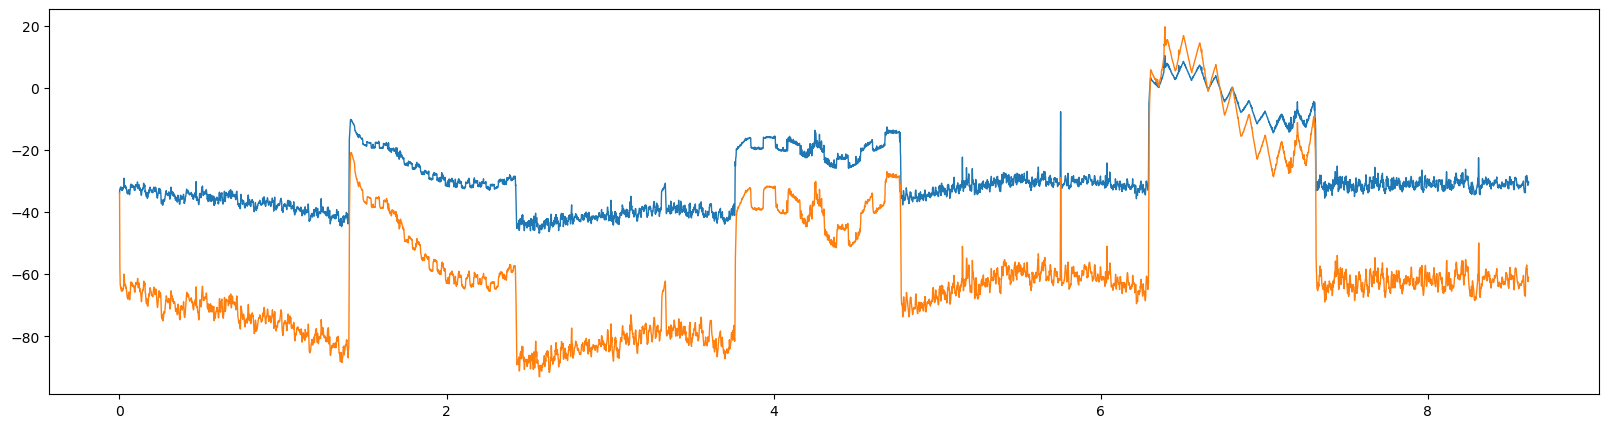

In [41]:
plt.subplots(figsize=(20,5))
plt.plot(df.Chainage, data['before'], label='before',lw=1)
#plt.plot(df.Chainage, data['after_fir'], label='FIR',lw=1)
plt.plot(df.Chainage, data['after_iir'], label='IIR',lw=1)
#plt.subplots(figsize=(10,5))

In [8]:
# x_med = signal.medfilt(data['before'],3)
# plt.subplots(figsize=(20,5))
# plt.plot(x_med, label='median',lw=1)

In [9]:
# b = np.ones(3)/3
# plt.subplots(figsize=(20,5))
# x_filt = signal.lfilter(b,1,data['before'])
# plt.plot(x_filt)

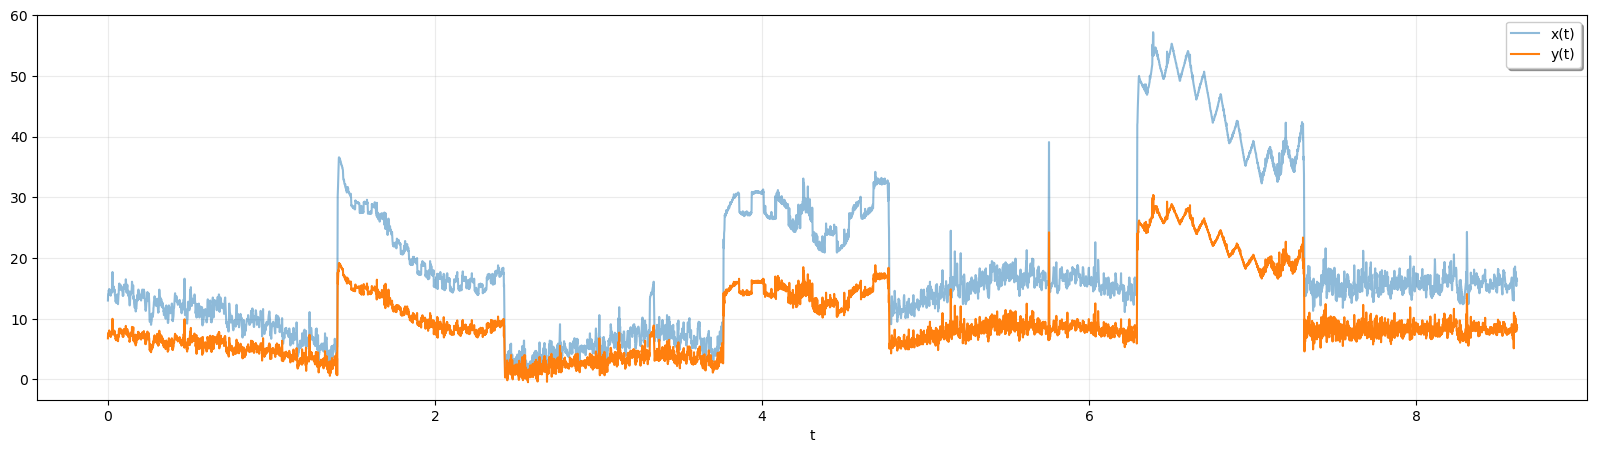

In [22]:
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt
from scipy.signal import sosfiltfilt, butter

def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    sos = scipy.signal.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = scipy.signal.sosfiltfilt(sos, data)
    return filtered_data

# Load sample data from a WAV file
#sample_rate, data = scipy.io.wavfile.read(df.Texture)
#times = np.arange(len(data))/sample_rate

#sosfiltfilt(sos.)
x = df.adjusted_Tex
sos = butter(6, 0.125, btype='highpass', analog=True, output='sos')
y = sosfiltfilt(sos, x)
t=df.Chainage

from scipy.signal import sosfilt, sosfilt_zi
#sos8 = butter(8, 0.125, output='sos')
#zi = x[:4].mean() * sosfilt_zi(sos8)
#y2, zo = sosfilt(sos8, x, zi=zi)
plt.subplots(figsize=(20,5))
plt.plot(t, x, alpha=0.5, label='x(t)')
plt.plot(t, y, label='y(t)')
#plt.plot(t, y2, label='y2(t)')
plt.legend(framealpha=1, shadow=True)
plt.grid(alpha=0.25)
plt.xlabel('t')
#plt.subplots(figsize=(20,5))
plt.show()

In [110]:
import numpy as np
from scipy.signal import butter,sosfiltfilt
import plotly.graph_objects as go

#sample_rate = (len(df)/2)/max(df.Chainage)

sample_period = max(df.Chainage)
sample_rate = 8000
n = len(df) # total number of samples
nyq = 0.5 * sample_rate
cutoff=1
order=8 # started at 2
data = df.adjusted_Tex

def butter_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    sos = butter(order, normal_cutoff, btype='highpass', analog=True, output='sos')
    y = sosfiltfilt(sos, data)
    return y

# Filter the data, and plot both the original and filtered signals.
filtered_y = butter_filter(data, cutoff, sample_rate, order)
fig = go.Figure()
# fig.add_trace(go.Scatter(
#             y = data,
#             line =  dict(shape =  'spline' ),
#             name = 'signal with noise'
#             ))
fig.add_trace(go.Scatter(
            y = filtered_y,
            line =  dict(shape =  'linear',
                         width=0.5 ),
            name = 'filtered signal'
            ))
fig.show()

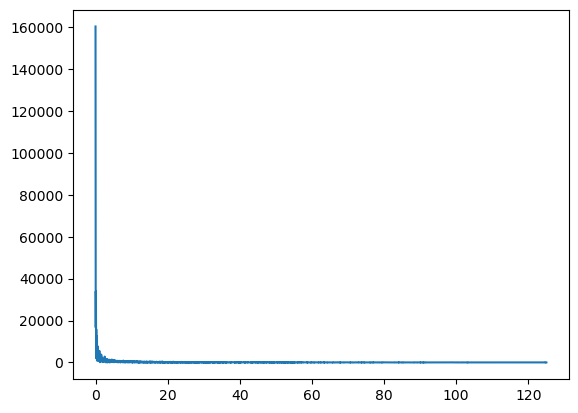

In [116]:
# now get the high frequency noise out...
# problem is that this data is not based on time but the x-axis is distance (mm)

from scipy.fft import rfft,rfftfreq,fftfreq
import numpy as np
import matplotlib.pyplot as plt

freqs = fftfreq(len(filtered_y), 8000)
t= np.arange(0,8000, 1)
from scipy.fft import rfft,rfftfreq
data_step   = 0.004
f_noise = filtered_y
n    = len(filtered_y)
yf   = rfft(f_noise)
xf   = rfftfreq(n,data_step)
#plt.plot(xf,np.abs(yf))

yf_abs      = np.abs(yf) 
indices     = yf_abs>1   # filter out those value under 300
yf_clean    = indices * yf # noise frequency will be set to 0
plt.plot(xf,np.abs(yf_clean))
#t           = np.arange(start=0,stop=1,step=data_step)

# n    = len(t)
# yf   = rfft(f_noise)
# xf   = rfftfreq(n,data_step)
# plt.plot(xf,np.abs(yf))


# yf_abs      = np.abs(filtered_y) 
# indices     = yf_abs>2   # filter out those value under 300
# yf_clean    = indices * filtered_y # noise frequency will be set to 0
# plt.plot(df.Chainage,np.abs(yf_clean))



In [117]:
n = len(df.Texture)
dt = 1
fhat = np.fft.fft(df.Texture, n)
psd = fhat * np.conj(fhat)/n
freq = (1/n) * np.arange(n) #frequency array
idxs_half = np.arange(1, np.floor(n), dtype=np.int32) #first half index

In [118]:
threshold = 10
signal = df.Texture[:8000]
signal_clean = signal
psd_idxs = psd > threshold #array of 0 and 1
psd_clean = psd * psd_idxs #zero out all the unnecessary powers
fhat_clean = psd_idxs * fhat #used to retrieve the signal
minsignal, maxsignal = signal.min(), signal.max()
signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform
signal_filtered = signal_filtered[:8000]

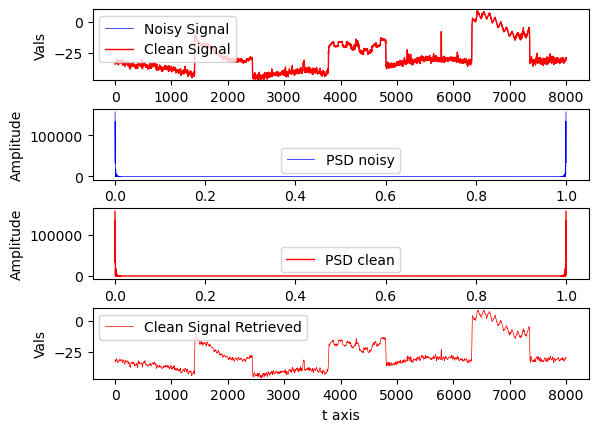

In [120]:
## Visualization

fig, ax = plt.subplots(4,1)
ax[0].plot(t, signal, color='b', lw=0.5, label='Noisy Signal')
ax[0].plot(t, signal_clean, color='r', lw=1, label='Clean Signal')
ax[0].set_ylim([minsignal, maxsignal])
ax[0].set_xlabel('t axis')
ax[0].set_ylabel('Vals')
ax[0].legend()

ax[1].plot(freq[idxs_half], np.abs(psd[idxs_half]), color='b', lw=0.5, label='PSD noisy')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(freq[idxs_half], np.abs(psd_clean[idxs_half]), color='r', lw=1, label='PSD clean')
ax[2].set_xlabel('Frequencies in Hz')
ax[2].set_ylabel('Amplitude')
ax[2].legend()

ax[3].plot(t, signal_filtered, color='r', lw=0.5, label='Clean Signal Retrieved')
ax[3].set_ylim([minsignal, maxsignal])
ax[3].set_xlabel('t axis')
ax[3].set_ylabel('Vals')
ax[3].legend()

plt.subplots_adjust(hspace=0.4)


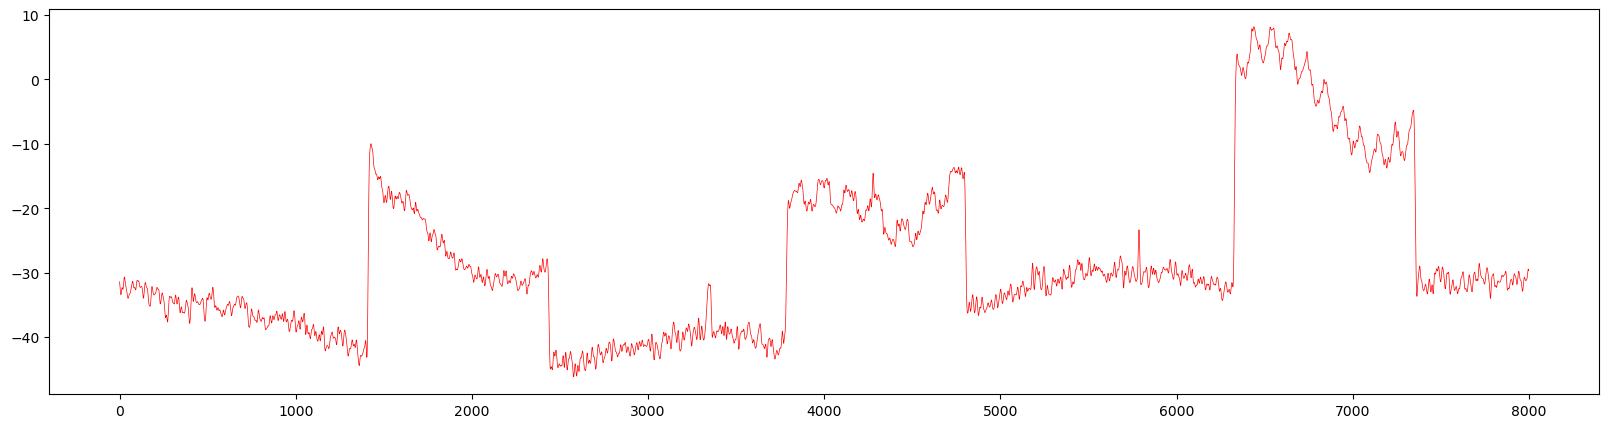

In [121]:
plt.subplots(figsize=(20,5))
plt.plot(t, signal_filtered, color='r', lw=0.5, label='Clean Signal Retrieved')
#plt.set_ylim([minsignal, maxsignal])
#plt.set_xlabel('t axis')
#plt.set_ylabel('Vals')


(-6.0, 8.0)

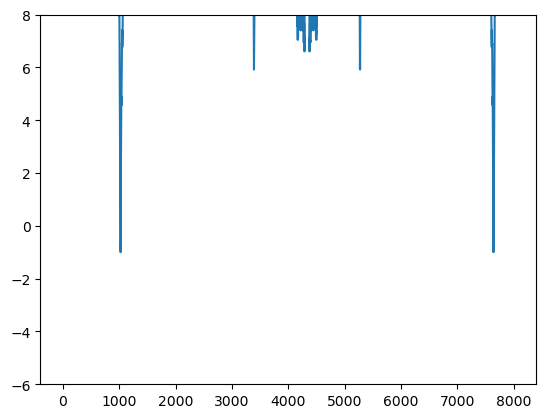

In [45]:
from scipy.fft import irfft
new_f_clean = irfft(yf_abs)
plt.plot(t,new_f_clean[:8000])
plt.ylim(-6,8)

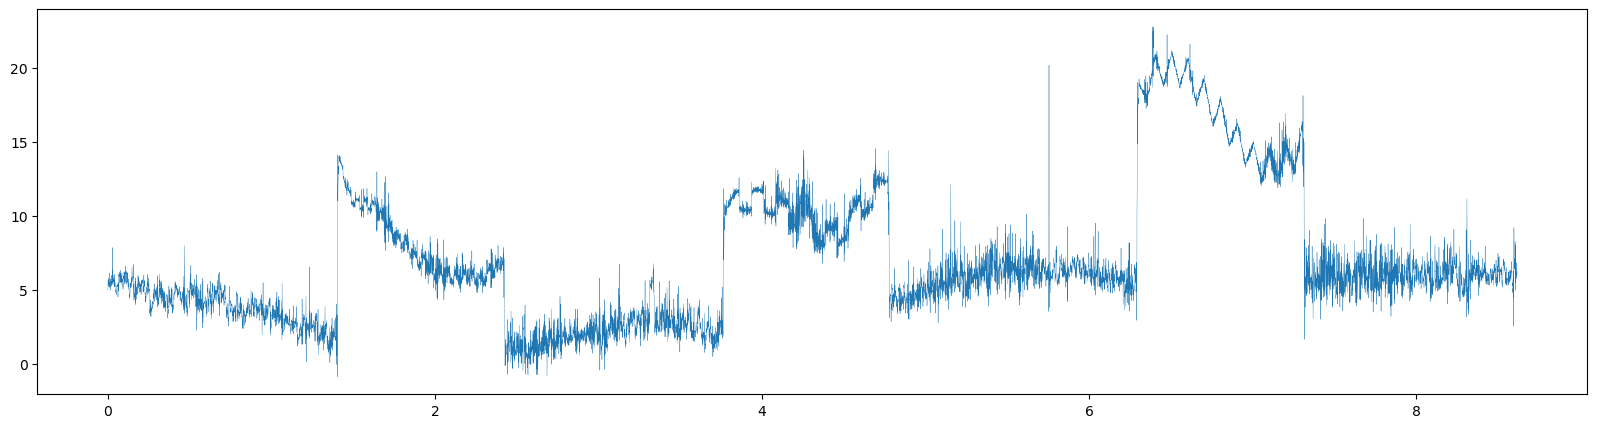

In [60]:
import matplotlib.pyplot as plt
import numpy as np

mu, sigma = 0, 500

#x = np.arange(1, len(df), 0.1)  # x axis
#z = np.random.normal(mu, sigma, len(x))  # noise
# y from previous cell
#y = x ** 2 + z  # data
plt.subplots(figsize=(20,5))
plt.plot(t, y, linewidth=0.25)  # it includes some noise

from scipy.signal import lfilter

n = 30  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
yy = lfilter(b, a, y)
#plt.plot(x, yy, linewidth=2, linestyle="-", c="b")  # smooth by filter

# from scipy.signal import savgol_filter
# w = savgol_filter(y, 50, 2)
# plt.plot( w, x, 'b')  # high frequency noise removed

In [32]:
# the frequency of the noise is the length of the signal/2
noise_frequency = (len(df)/2)/ max(df.Chainage)

sos = signal.butter(4, Wn=(noise_frequency/4), btype='highpass', fs=(noise_frequency*2), output='sos')
filtered = signal.sosfilt(sos, sig)
ax2.plot(t, filtered)
ax2.set_title('After 15 Hz high-pass filter')
ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show() 


NameError: name 'sig' is not defined

In [11]:
# max(df.Chainage)/len(df.Chainage) * 2

In [12]:
# n = len(df.Chainage)
# fhat = np.fft.fft(y, n) #computes the fft
# psd = fhat * np.conj(fhat)/n
# #freq = (1/(dt*n)) * np.arange(n) #frequency array
# hertz = max(df.Chainage)/len(df.Chainage) * 2
# idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index

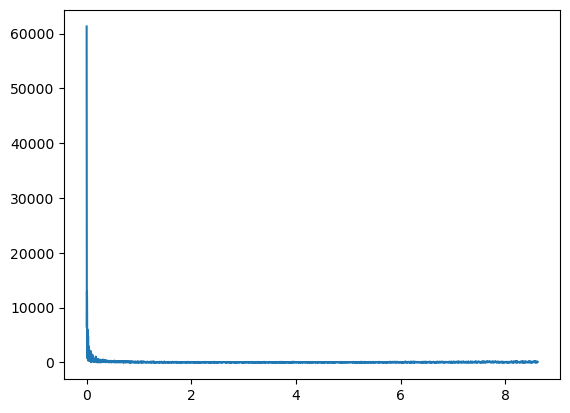

In [13]:
# remove the noise from the filtered signal
# the filtered signal is y from cell above

from scipy.fft import rfft,rfftfreq
n    = len(t)
yf   = rfft(y)
x =df.Chainage[::2]

y=np.abs(yf)
y = np.delete(y, -1)
#xf   = rfftfreq(n,data_step)
plt.plot(x,y)

0.000994262919801523
8.616282463


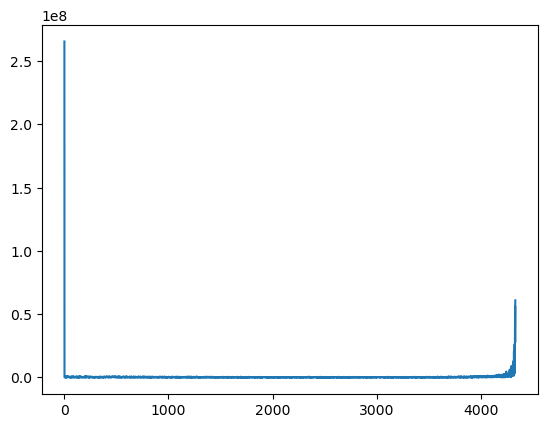

In [20]:
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
SAMPLE_RATE = max(df.Chainage)/len(df.Chainage)
print(SAMPLE_RATE)
DURATION = max(df.Chainage)
print(DURATION)
N = int(len(df))
temp_fft = scipy.fftpack.fft(np.array(y))
yf = scipy.fftpack.fft(temp_fft, axis=-1)
#yf = fft(normalized_tone)
xf = fftfreq(N, 1/SAMPLE_RATE)

plt.plot(np.abs(yf))
plt.show()

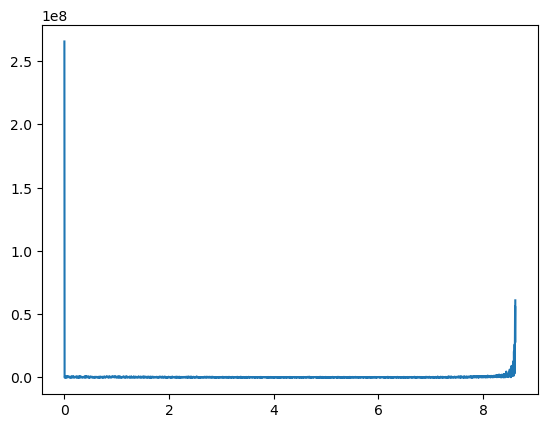

In [24]:
#points_per_freq = len(xf)/(SAMPLE_RATE/2)
#target_idx = int(points_per_freq * 4000)
xf = df.iloc[1::2]
xf= xf.Chainage
yf[1 : 4] = 0
plt.plot(xf, np.abs(yf))
plt.show()

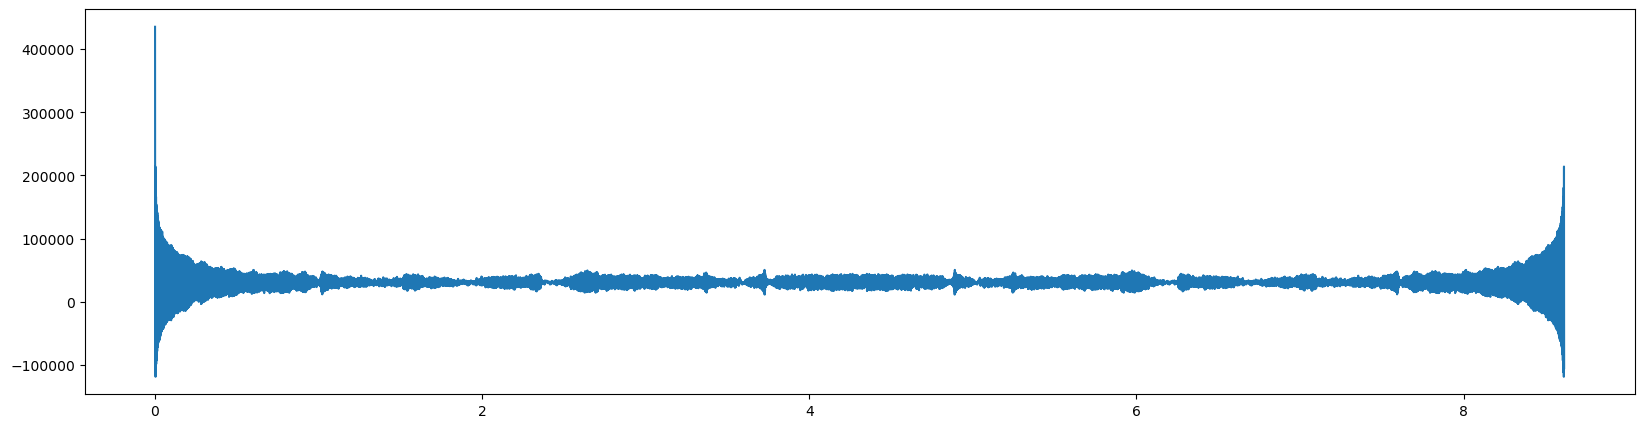

In [29]:
from scipy.fft import irfft

new_sig = irfft(yf)
df_sub = df.head(-2)
plt.subplots(figsize=(20,5))
plt.plot(df_sub.Chainage, new_sig)
plt.show()

In [ ]:
import scipy.signal

d1 = df.Texture
N = len(d1)
#d1_fft = fft(df.adjusted_Tex)
x_axis = d1[1:N]
#f = LinRange(-0.5, 0.5, N+1)[1:N]  # normalized frequency 
fs = 1;   # sampling frequency
fc = 0.005;  # frequency cutoff, less than Fnyquist=0.5
filt = digitalfilter(Highpass(fc,fs=fs), Butterworth(6));
d2 = filtfilt(filt, d1)  #filtered signal
p1 = plot(x_axis[1:N], d2[1:N], lw=1,label="Filtered flipped signal",xlabel="Time", legend=topleft)
#plot!(t[1:N÷2], d3_trunc[1:N÷2], ls=:dash,lc=:black, lw=1,label="From truncated spectrum (100 points)")
plot(p1, size=(4000,1000))

In [ ]:
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt

def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    sos = scipy.signal.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = scipy.signal.sosfiltfilt(sos, data)
    return filtered_data

# Load sample data from a WAV file
sample_rate, data = scipy.io.wavfile.read(df.Texture)
times = np.arange(len(data))/sample_rate

# Apply a 10-50 Hz high-pass filter to the original data
filtered = bandpass(data, [10, 50], sample_rate)